In [1]:
# define experiment parameters

# [-500 ~ 500]
WL=0; WW=1000

In [2]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import os
import glob

import matplotlib.pyplot as plt
%matplotlib inline

# Read Dicom

In [3]:
def read_dicom(path):
    g = glob.glob(os.path.join(path, '*.dcm'))
    slices = [pydicom.read_file(s) for s in g]
    slices.sort(key=lambda x: int(x.InstanceNumber))
#     print('RescaleIntercept :{}'.format(slices[0].RescaleIntercept))
#     print('RescaleSlope :{}'.format(slices[0].RescaleSlope))
#     print('SliceThickness :{}'.format(slices[0].SliceThickness))
#     print('Pixel Spacing  :{}'.format(slices[0].PixelSpacing ))

    return slices

In [4]:
def hu_window(scan, window_level=40, window_width=80, show_hist = False):
    scan = scan.pixel_array.copy()
    window = [window_level-window_width/2, window_width/2-window_level]
    
    scan = np.where(scan < window[0], window[0], scan)
    scan = np.where(scan > window[1], window[1], scan)
    
    if show_hist:
        plt.figure(0, figsize=(6,6))
        plt.imshow(scan, 'gray')

        plt.figure(1, figsize=(6,6))
        plt.hist(scan.flatten(), color='c')
        plt.xlabel("Hounsfield Units (HU)")
        plt.ylabel("Frequency")
        plt.show()

    return scan

In [5]:
def show_raw_pixel(slices):
    #讀出像素值並且儲存成numpy的格式
    image = hu_window(slices, window_level=0, window_width=1000,  show_hist=False)
#     plt.figure(figsize = (12,12))
    plt.imshow(image, cmap=plt.cm.gray)
    plt.show()

In [6]:
# return  a region where cbct images aren't all black
def valid_slices(cbcts, cts):
    found_start = False
    start = 0
    end = -1
    
    # iterate through cbct slices, and find which regions aren't all black (-1000)
    for idx, sli in enumerate(cbcts):
        image = sli.pixel_array
        
        if not found_start and len(np.unique(image))!=1:
            start = idx
            found_start = True
                                   
        elif found_start and len(np.unique(image)) == 1:
            end = idx
            break
        
    return start, end
                                   

## read two slices

In [7]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [9]:
class Dataset(BaseDataset):
    """
    Args:
        path (str): path to dataset
        x_channel (int): number of channels for X(images)
        y_channel (int): number of channels for y(masks)
        do_resize (tuple of ints): resize the image and mask, if None, DO NOT do resize
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self,
            path,
    ):
        paths = sorted(glob.glob(path))
        self.xs = []
        self.ys = []
        
        # read cbct and ct
        for i in range(0, len(paths), 2):
            cbct_slices = read_dicom(paths[i])
            ct_slices = read_dicom(paths[i+1])

            region = valid_slices(cbct_slices, ct_slices)
            # ditch first and last 3
            self.xs = self.xs + cbct_slices[region[0] + 3: region[1] - 3]
            self.ys = self.ys + ct_slices[region[0] + 3: region[1] - 3]
            
        # set both cbct and ct to same WL and WW (0, 1000)
        self.xs = [hu_window(cbct, window_level=WL, window_width=WW,  show_hist=False) for cbct in self.xs]
        self.ys = [hu_window(ct, window_level=0, window_width=1000,  show_hist=False) for ct in self.ys]
        
    
    def __getitem__(self, i):

        # read img
        x = self.xs[i]
        y = self.ys[i]
        
        x = np.expand_dims(x, 0).astype(np.float32)
        y = np.expand_dims(y, 0).astype(np.float32)
        
#         crop_size = (64, 448)
#         x = x[:, crop_size[0]:crop_size[1], crop_size[0]:crop_size[1]]
#         y = y[:, crop_size[0]:crop_size[1], crop_size[0]:crop_size[1]]

        return x, y
        
    def __len__(self):
        return len(self.xs)

In [10]:
testset = Dataset(test_case_path)

In [11]:
x, y = testset[4]

(<matplotlib.image.AxesImage at 0x7f6233c9fc18>,)

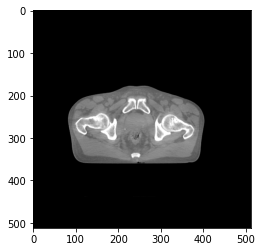

In [12]:
plt.imshow(x.squeeze(), 'gray'),

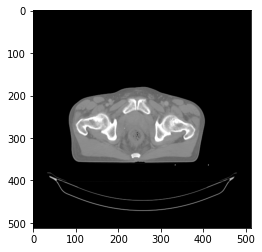

In [13]:
plt.imshow(y.squeeze(), 'gray')

In [14]:
x.shape

(1, 512, 512)

In [15]:
with torch.no_grad():
    pr = model(torch.tensor(x).unsqueeze(0).cuda())

plt.imshow(pr.cpu().numpy().squeeze(), 'gray')

NameError: name 'torch' is not defined

# Eval

In [16]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

In [17]:
class MAELoss(nn.L1Loss):
  def __init__(self):
    nn.L1Loss.__init__(self)
    self.__name__ = 'mae_loss'

In [18]:
loss = MAELoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [19]:
test_loaders = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=0)

## Model

In [138]:
save_model_path = 'weights/save_model_unet_se_resnext50_32x4d.pth'

In [149]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(encoder_name='se_resnext50_32x4d', encoder_weights=None, in_channels=1, classes=1)

DEVICE = 'cpu'
if torch.cuda.is_available():
    print('using gpu')
    DEVICE = 'cuda'
    model.cuda()
else:
    print('using cpu')
    
model.load_state_dict(torch.load(save_model_path, map_location=DEVICE))

using gpu


<All keys matched successfully>

In [150]:
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

# Metrics

## MAE

In [151]:
valid_logs = valid_epoch.run(test_loaders)

# MAE
valid_logs['mae_loss']

valid: 100%|██████████| 191/191 [00:04<00:00, 43.13it/s, mae_loss - 17.64, iou_score - -0.03032]


17.636895684047527

## SNR

In [152]:
def signaltonoise(ct, cbct):
        '''
        input tensors of same shape

        return SNR
        '''
        upper = torch.sum(torch.pow(ct, 2))
        lower = torch.sum(torch.pow(ct - cbct, 2))
        
        return 10 * torch.log10(upper / lower)

In [153]:
snr_collect = []

In [154]:
from tqdm import tqdm

for x, y in tqdm(test_loaders):
        y = y.cuda()
        # inference
        with torch.no_grad():
            pred = model(torch.tensor(x).cuda())
        
        snr_collect.append(signaltonoise(pred, y).item())

  0%|          | 0/191 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
100%|██████████| 191/191 [00:04<00:00, 45.59it/s]


In [155]:
np.mean(snr_collect)

16.914120629195768

## structural similarity

https://github.com/Po-Hsun-Su/pytorch-ssim/blob/master/pytorch_ssim/__init__.py

In [156]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.02**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

In [165]:
ssim = SSIM()

In [166]:
ssim_collect = []

In [167]:
from tqdm import tqdm

for x, y in tqdm(test_loaders):
        x = x.cuda()
        y = y.cuda()
        # inference
        with torch.no_grad():
                pred = model(torch.tensor(x).cuda())
        
        ssim_collect.append(ssim(pred, y).item())

  0%|          | 0/191 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
100%|██████████| 191/191 [00:04<00:00, 41.18it/s]


In [168]:
np.mean(ssim_collect)

1.3890811492011186

# Testing

In [123]:
def cliphu(img, wl, ww):
    '''
    clip the window level
    '''
    img[img < (wl-ww)/2] = (wl-ww)/2
    img[img > (wl+ww)/2] = (wl+ww)/2
    
    return img

In [124]:
x,y = testset[26]

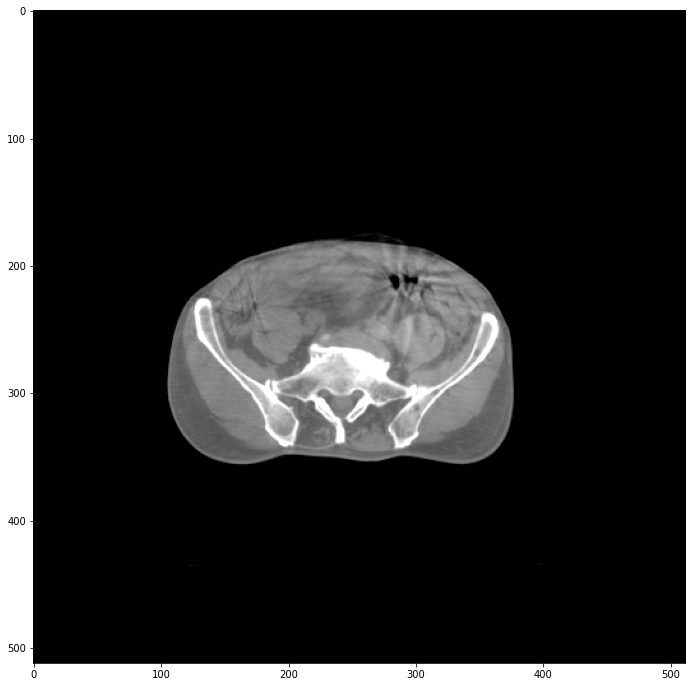

In [125]:
plt.figure(figsize=(12,12))
plt.imshow(x.squeeze(), 'gray')

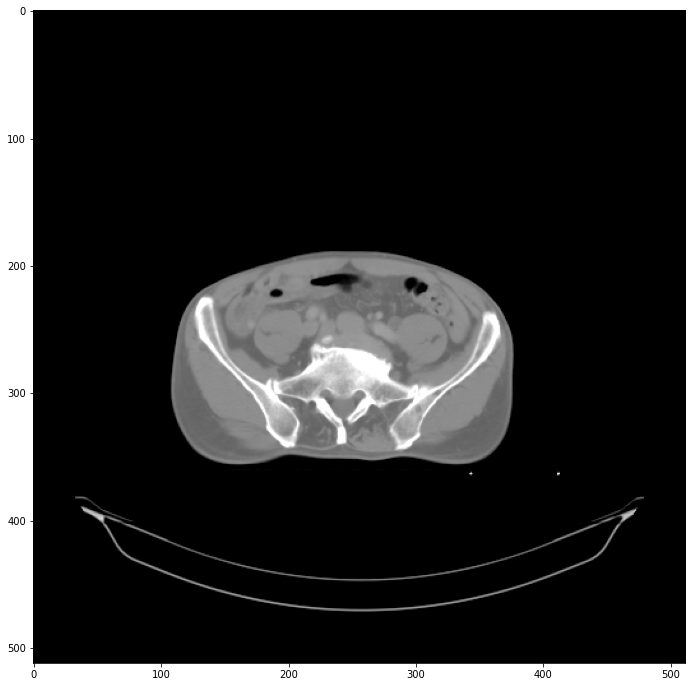

In [126]:
plt.figure(figsize=(12,12))
plt.imshow(y.squeeze(), 'gray')

In [127]:
model.load_state_dict(torch.load(save_model_path))
model.eval()
print('eval mode')

eval mode


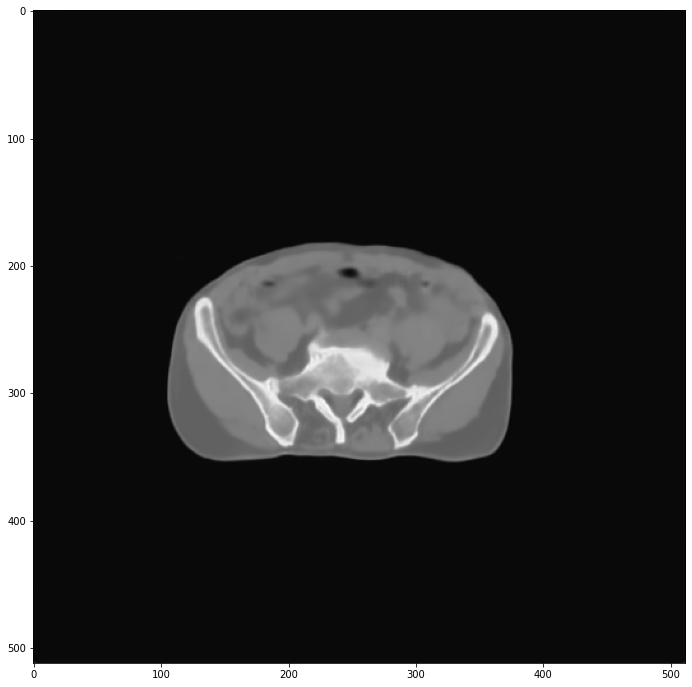

In [128]:
with torch.no_grad():
    pred = model(torch.tensor(x).unsqueeze(0).cuda())
    
    pred_img = pred.cpu().squeeze().numpy()
    
plt.figure(figsize=(12,12))
plt.imshow(pred_img, 'gray')

In [129]:
x,y = testset[5]

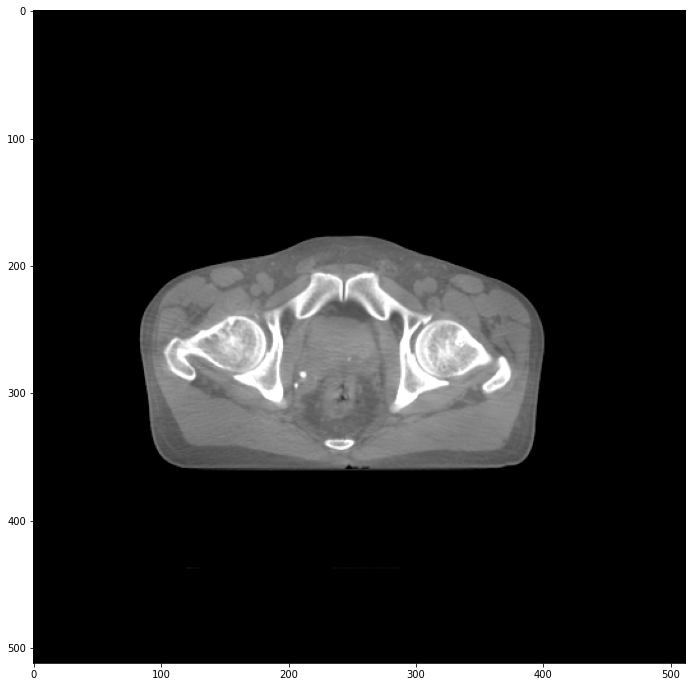

In [130]:
plt.figure(figsize=(12,12))
plt.imshow(x.squeeze(), 'gray')

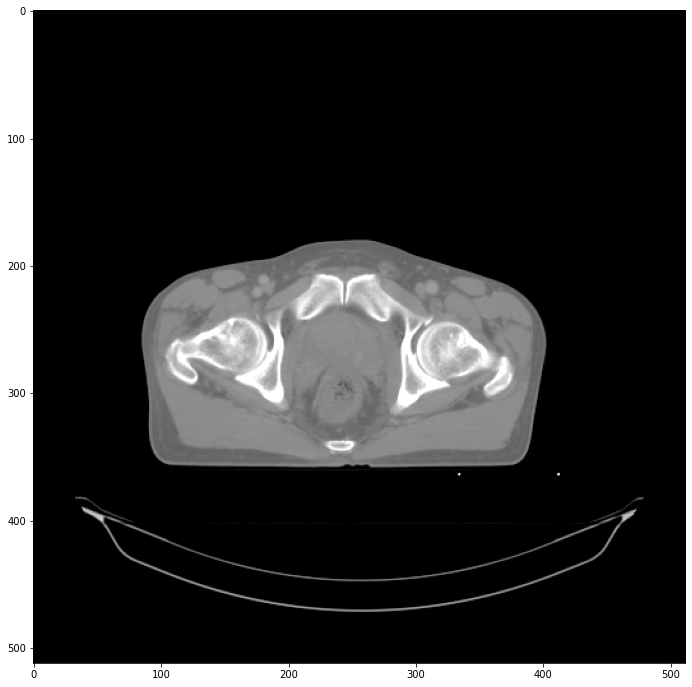

In [131]:
plt.figure(figsize=(12,12))
plt.imshow(y.squeeze(), 'gray')

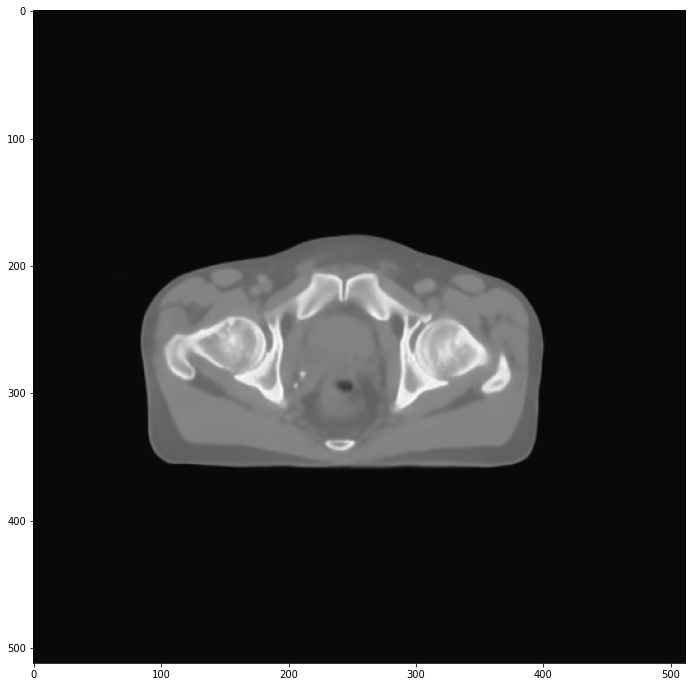

In [132]:
with torch.no_grad():
    pred = model(torch.tensor(x).unsqueeze(0).cuda())
    
    pred_img = pred.cpu().squeeze().numpy()
    
plt.figure(figsize=(12,12))
plt.imshow(pred_img, 'gray')

## inference through the testset

In [133]:
from tqdm import tqdm

In [45]:
test_result_path = 'data/results/'

In [46]:
idx = 0
for x, y in tqdm(testset):
    with torch.no_grad():
        pred = model(torch.tensor(x).unsqueeze(0).cuda())

        pred_img = pred.cpu().squeeze().numpy()
        
        # normalize to image
        r = ((pred_img-np.min(pred_img))/(np.max(pred_img)-np.min(pred_img)) * 255).astype(np.uint8)
        _y = ((y+500)/1000 * 255).astype(np.uint8)
        _x = ((x+500)/1000 * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(test_result_path, 'reconstructed/{}_pr.png'.format(idx)), r)
        cv2.imwrite(os.path.join(test_result_path, 'gt/{}_y.png'.format(idx)), _y.squeeze())
        cv2.imwrite(os.path.join(test_result_path, 'origin/{}_x.png'.format(idx)), _x.squeeze())
        idx+=1

100%|██████████| 191/191 [00:07<00:00, 26.41it/s]


In [47]:
np.min(pred_img), np.max(pred_img)

(-543.0152, 653.647)

In [48]:
np.min(y), np.max(y)

(-500.0, 500.0)

In [49]:
np.min(x), np.max(x)

(-500.0, 500.0)